In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from createDataset.params import *
import os
import json
import pandas as pd

In [2]:
LOCAL_PATH = "../data/"
WIKI_DATA = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")

In [3]:
# create the session
spark = SparkSession.builder.getOrCreate()
# create the context
sc = spark.sparkContext

df = spark.read.json(WIKI_DATA)

In [4]:
df.show()

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|        ['Q3246315']|August William Kj...|   A. W. Kjellstrand|
|Q6581097| Q4661199|    Aage Fahrenholtz|       ['Q1133

In [5]:
df = df.withColumn("occupation", explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))

In [6]:
df.show()

+--------+---------+--------------------+----------+--------------------+--------------------+
|  gender|       id|                name|occupation|            overview|          wiki-title|
+--------+---------+--------------------+----------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|          |Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|   Q177220|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4647941|       A. J. Masters|   Q753110|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...| Q13582652|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4648064|A. L. A. Himmelwr...|    Q81096|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|  Q1234713|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|    Q43845|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|  Q324631

In [7]:
df = df.filter(col("occupation") != '')

In [8]:
df.show()

+--------+---------+--------------------+----------+--------------------+--------------------+
|  gender|       id|                name|occupation|            overview|          wiki-title|
+--------+---------+--------------------+----------+--------------------+--------------------+
|Q6581097| Q4647941|       A. J. Masters|   Q177220|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4647941|       A. J. Masters|   Q753110|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...| Q13582652|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4648064|A. L. A. Himmelwr...|    Q81096|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|  Q1234713|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|    Q43845|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|  Q3246315|August William Kj...|   A. W. Kjellstrand|
|Q6581097| Q4661199|    Aage Fahrenholtz| Q1133857

In [9]:
dict_occupations = {}

with open('../data/dict_occupations.json') as json_file:
    content = json_file.readlines()
    for line in content:
        occ = json.loads(line)
        dict_occupations.update(occ)

In [10]:
def get_occupation(occ):
    return dict_occupations.get(occ, "other")

In [11]:
# get the adjectives
udf_get_occ = udf(get_occupation)
df = df.withColumn("occupation", udf_get_occ("occupation"))

In [12]:
df.show()

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097| Q4647941|       A. J. Masters|              singer|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4647941|       A. J. Masters|          songwriter|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|      civil engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4648064|A. L. A. Himmelwr...|            engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|          theologian|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|      businessperson|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|          head

In [13]:
with open('../data/dict_categories_occupations.json') as json_file:
    line = json_file.readline()
    dict_cat_occ = json.loads(line)

In [14]:
def get_occupation_category(occ):
    return dict_cat_occ.get(occ, "Other")

In [15]:
# get the adjectives
udf_get_occ_cat = udf(get_occupation_category)
df = df.withColumn("field", udf_get_occ_cat("occupation"))

In [16]:
df = df.filter(col("field") != "Other")
df = df.select("gender", "id", "field")

In [17]:
df = df.dropDuplicates()
df.show()

+--------+---------+--------------+
|  gender|       id|         field|
+--------+---------+--------------+
|Q6581097| Q6812078|      Politics|
|Q6581072| Q3617827|        Artist|
|Q6581097|Q19873347|        Sports|
|Q6581097| Q2883676|      Military|
|Q6581097| Q3638477|      Religion|
|Q6581097|Q19840044|      Politics|
|Q6581072| Q5031111|Business & Law|
|Q6581097|Q21061864|        Sports|
|Q6581097| Q5272725|        Sports|
|Q6581072| Q5322029|        Artist|
|Q6581097| Q5339568|        Sports|
|Q6581097|Q18280917|     Education|
|Q6581097| Q5525191|Business & Law|
|Q6581097| Q5538003|        Sports|
|Q6581097|  Q216115|        Artist|
|Q6581097| Q1581561|        Artist|
|Q6581097|Q16066494|Business & Law|
|Q6581097| Q5932467|        Artist|
|Q6581097| Q5982013|        Sports|
|Q6581097|Q28024774|        Sports|
+--------+---------+--------------+
only showing top 20 rows



In [18]:
occupation_counts = df.groupBy("field").agg(count("*").alias("count")).sort(desc("count"))
occupation_counts.show()

+---------------+------+
|          field| count|
+---------------+------+
|         Sports|381505|
|         Artist|351666|
|       Politics|205882|
| Business & Law| 82712|
|Social Sciences| 77480|
|      Scientist| 69893|
|      Education| 42564|
|       Military| 35055|
|       Religion| 26789|
|          Model| 10820|
+---------------+------+



In [19]:
occupation_counts.count()

10

In [20]:
occ_counts_pd = occupation_counts.toPandas()
occ_counts_pd

,field,count
0,Sports,381505
1,Artist,351666
2,Politics,205882
3,Business & Law,82712
4,Social Sciences,77480
5,Scientist,69893
6,Education,42564
7,Military,35055
8,Religion,26789
9,Model,10820


In [21]:
pl = occ_counts_pd.plot(kind="bar", x="field", y="count", figsize=(10, 7), log=False, alpha=0.5, color="green")
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by field of occupation");

In [22]:
n_total = occ_counts_pd['count'].sum()
n_artist = occ_counts_pd[occ_counts_pd['field'] == 'Artist']['count'].values[0]
n_sports = occ_counts_pd[occ_counts_pd['field'] == 'Sports']['count'].values[0]
n_politics = occ_counts_pd[occ_counts_pd['field'] == 'Politics']['count'].values[0]

print("{:.2f}% of the entries work in the artistic field".format(n_artist/n_total*100))
print("{:.2f} % of the entries work in the sports field".format(n_sports/n_total*100))
print("{:.2f} % of the entries work in the politics field".format(n_politics/n_total*100))

27.38% of the entries work in the artistic field
29.70 % of the entries work in the sports field
16.03 % of the entries work in the politics field


In [23]:
occupation_counts_by_gender = df.groupBy("field", "gender").agg(count("*").alias("count")).sort(desc("count"))
occupation_counts_by_gender.show()

+---------------+--------+------+
|          field|  gender| count|
+---------------+--------+------+
|         Sports|Q6581097|345506|
|         Artist|Q6581097|256905|
|       Politics|Q6581097|182148|
|         Artist|Q6581072| 94761|
| Business & Law|Q6581097| 75121|
|Social Sciences|Q6581097| 63207|
|      Scientist|Q6581097| 63082|
|         Sports|Q6581072| 35999|
|      Education|Q6581097| 35815|
|       Military|Q6581097| 34501|
|       Religion|Q6581097| 26407|
|       Politics|Q6581072| 23734|
|Social Sciences|Q6581072| 14273|
|          Model|Q6581072|  8804|
| Business & Law|Q6581072|  7591|
|      Scientist|Q6581072|  6811|
|      Education|Q6581072|  6749|
|          Model|Q6581097|  2016|
|       Military|Q6581072|   554|
|       Religion|Q6581072|   382|
+---------------+--------+------+



In [24]:
with open('../data/dict_genders.json') as json_file:
    line = json_file.readline()
    dict_genders = json.loads(line)

In [25]:
def get_gender(gender):
    return dict_genders.get(gender)

In [26]:
# get the adjectives
udf_get_gender = udf(get_gender)
occupation_counts_by_gender = occupation_counts_by_gender.withColumn("gender", udf_get_gender("gender"))
occupation_counts_by_gender.show()

+---------------+------+------+
|          field|gender| count|
+---------------+------+------+
|         Sports|  male|345506|
|         Artist|  male|256905|
|       Politics|  male|182148|
|         Artist|female| 94761|
| Business & Law|  male| 75121|
|Social Sciences|  male| 63207|
|      Scientist|  male| 63082|
|         Sports|female| 35999|
|      Education|  male| 35815|
|       Military|  male| 34501|
|       Religion|  male| 26407|
|       Politics|female| 23734|
|Social Sciences|female| 14273|
|          Model|female|  8804|
| Business & Law|female|  7591|
|      Scientist|female|  6811|
|      Education|female|  6749|
|          Model|  male|  2016|
|       Military|female|   554|
|       Religion|female|   382|
+---------------+------+------+



In [27]:
occ_by_gender_pd = occupation_counts_by_gender.toPandas()
occ_by_gender_pd = occ_by_gender_pd.sort_values(by="field").reset_index(drop=True)
occ_by_gender_pd

,field,gender,count
0,Artist,male,256905
1,Artist,female,94761
2,Business & Law,male,75121
3,Business & Law,female,7591
4,Education,female,6749
5,Education,male,35815
6,Military,male,34501
7,Military,female,554
8,Model,male,2016
9,Model,female,8804


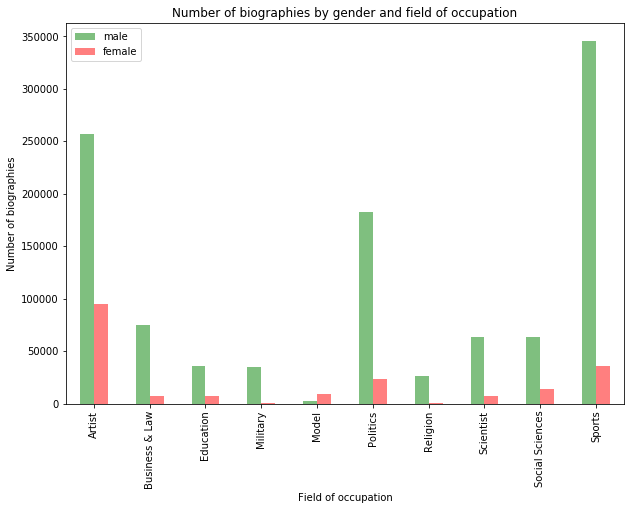

In [28]:
male_count = occ_by_gender_pd[occ_by_gender_pd['gender'] == 'male']['count'].tolist()
female_count = occ_by_gender_pd[occ_by_gender_pd['gender'] == 'female']['count'].tolist()
index = occ_by_gender_pd['field'].unique().tolist()
occ_by_gender = pd.DataFrame({'male': male_count, 'female': female_count}, index=index)

pl = occ_by_gender.plot(kind="bar", figsize=(10, 7), log=False, alpha=0.5, color=["green", "red"])
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender and field of occupation");